# Testing Dynamics

This notebook serves to test the `dynamics` (sub)module which implements various dynamical systems for learning.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# from functools import partial

from dynamics.lorenz import lorenz_derivative
from dynamics.spp import spp_derivative
from dynamics.limit_cycle import wilson_cowan_derivative
from dynamics.stochastic import stochastic_differential, sdeint_em

from scipy.integrate import solve_ivp

## Lorenz System

In [3]:
state0 = (1.,1.,1.)
t_span = (0.,26.)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Lorenz dynamics are chaotic,
# so let's see what happens if we use different integration schemes
methods = dict(rk45='RK45', dop853='DOP853')
integration_results = dict()
for method, method_val in methods.items():
    integration_results[method] = solve_ivp(
        lorenz_derivative,  # using default parameter values
        t_span=t_span,
        y0=state0,
        t_eval=t_eval,
        method=method_val
    )

In [4]:
def plot_3d_path(ax, states, color='blue', lw=0.5, **plot_kwargs):
    xs, ys, zs = states
    plot_kwargs['color'] = color
    plot_kwargs['lw'] = lw
    ax.plot(xs, ys, zs, **plot_kwargs)
    return ax

fig = plt.figure(figsize=(6,4), dpi=150)
ax = plt.axes(projection='3d')
fig.add_subplot(ax)

for i, (method, res) in enumerate(integration_results.items()):
    plot_3d_path(
        ax, res.y,
        label=method, color=f"C{i}")
fig.legend(title="method")
fig.suptitle("Lorenz System");

## Self-Propelled Particles

A small note: boundary forces should probably have a component tangential to the boundary, with the strength of this component force growing as the spp approaches the boundary, and growing as the spp velocity aligns with the boundary, while the remainder of the force pulls torwards the center. Why this latter point? Because if the fish direction is orthogonal to the boundary, the force would zero out, and if we discard this remainder, the force becomes discontinuous which is difficult to fit with a neuralode.

This can probably be vectorised, but the idea is plotted below.

In [5]:
pos = np.array([
    [1.,3.],
    [1,-3.],
    [4.,4.],
    [-4.,-4.]
])

vel = np.array([
    [1.,0.5],
    # [-1., 1.]
])
force_strength = 1.

plt.figure(figsize=(5,5))
for i, (x,y) in enumerate(pos):
    # plot location and velocity
    plt.plot(
        [0.,x], [0.,y], color='C'+str(i), lw=0.5,
        label='position' if i == 0 else None)
    plt.plot([x, x+vel[0,0]], [y, y+vel[0,1]], color='C'+str(i),
        label='velocity' if i == 0 else None)
    
    # compute normalised velocity
    vel_normed = vel.ravel() / np.sum(vel.ravel()**2)**(0.5)
    
    # compute orthogonal vector
    orthog = np.array([y,-x])
    orthog = orthog/ np.sum(orthog**2)**(0.5)
    cos_angle_with_boundary = np.dot(orthog, vel_normed)
    orthog_sign = np.sign(cos_angle_with_boundary)
    orthogonal_force_weighting = np.abs(cos_angle_with_boundary)
    orthog = orthogonal_force_weighting * orthog_sign * orthog
    
    # compute central force component
    central_force_weighting = 1. - orthogonal_force_weighting
    pos_direction = np.array([x,y])
    pos_direction = pos_direction / np.sum(pos_direction**2)**(0.5)
    central_comp = -central_force_weighting * pos_direction
    
    # create force vector
    force = force_strength*(orthog + central_comp)
    
    # plot force vector
    plt.plot([x, x+force[0]], [y, y+force[1]],
             color='C'+str(i), ls='--',
            label='force direction' if i == 0 else None)
    
plt.xlim([-6,6])
plt.ylim([-6,6])
plt.legend()
plt.title("Potential Boundary Forces");

In [6]:
num_individuals = 5
state0 = np.random.randn(4, num_individuals).reshape(-1)

# create vector-valued function
fun = lambda t,state: spp_derivative(
    t, state, 
    boundary_push=False,
    normalised=True,
    ).reshape(-1)

t_span = (0., 10.)
t_eval = np.linspace(t_span[0], t_span[1], 100)

# is this system chaotic?
methods = dict(
    rk45='RK45',
    dop853='DOP853'
)
integration_results = dict()
for method, method_val in methods.items():
    integration_results[method] = solve_ivp(
        fun,  # using default parameter values
        t_span=t_span,
        y0=state0,
        t_eval=t_eval,
        method=method_val
    )

In [7]:
legend_lines = []  # for the legend
step_size = 5  # for graduating fading of plot

for method, ls in zip(integration_results, ['-', '--']):
    legend_lines.append(plt.Line2D([],[], ls=ls, label=method))
    
    trajectory = integration_results[method].y.reshape(
        4, num_individuals, t_eval.shape[0])
    
    for focal_idx in range(num_individuals):
        color = "C"+str(focal_idx)
        for i, j in zip(
            range(0, trajectory.shape[-1]-step_size, step_size),
            range(step_size, trajectory.shape[-1], step_size)
        ):
            plt.plot(
                trajectory[0, focal_idx, i:j+1],
                trajectory[1, focal_idx, i:j+1],
                color=color,
                alpha=j/trajectory.shape[-1],
                ls=ls
            )
plt.legend(
    legend_lines,
    [l.get_label() for l in legend_lines],
    title='method')
plt.title("Self-Propelled Particles");

## Wilson-Cowan Model

The Wilson-Cowan model is used because it has a limit cycle.

In [8]:
t_span = (0., 10.)
t_eval = np.linspace(t_span[0], t_span[1], 100)

state0 = np.array((.5,.5))

methods = dict(rk45='RK45', dop853='DOP853')
integration_results = dict()
for method, method_val in methods.items():
    integration_results[method] = solve_ivp(
        wilson_cowan_derivative,  # using default parameter values
        t_span=t_span,
        y0=state0,
        t_eval=t_eval,
        method=method_val
    )

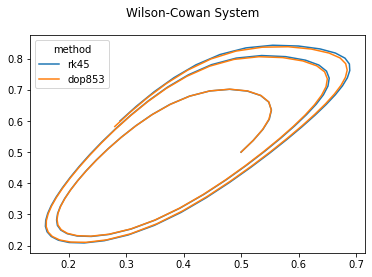

In [9]:
for i, (method, res) in enumerate(integration_results.items()):
    plt.plot(res.y[0,:], res.y[1,:],
        label=method, color=f"C{i}")
plt.legend(title="method")
plt.suptitle("Wilson-Cowan System");

## Harmonic Oscillator (TODO)

## Stochastic

Here we see how to take a deterministic system and use it as the drift part of an Itô process. We need a function that determines the strength of the diffusion and a matrix which describes the covariance of the underlying Brownian motion.

In [20]:
# Let's say hypothetically that noise is proportional to the
# square root of the firing rate
diffusion_strength = lambda t,state: np.diag(np.sqrt(state))

# And the Brownian motion is *slightly* correlated and small
brownian_covariance = np.eye(*state0.shape)*4 + np.random.randn(*state0.shape,*state0.shape)
brownian_covariance = brownian_covariance / 1000.
delta_t = 0.001

# half the samples will start elsewhere
state0_v2 = np.array((0.9, 0.9))

times = np.arange(0., 10., delta_t)
num_samples = 20
states = np.zeros((times.shape[0], state0.shape[0], num_samples))
states[0,:,:num_samples//2] = state0.reshape(-1,1).repeat(num_samples//2,1)
states[0,:,num_samples//2:] = state0_v2.reshape(-1,1).repeat(num_samples//2,1)

# Integrate with Euler-Maruyama method
# we can parallelise obtaining multiple samples,
# but I shan't here
for sample_idx in range(num_samples):
    for i, t in enumerate(times[:-1]):
        differential = stochastic_differential(
            t=t,
            state=states[i,:,sample_idx],
            drift_func=wilson_cowan_derivative,
            diffusion_func=diffusion_strength,
            brownian_covariance=brownian_covariance,
            covariance_is_diagonal=False,
            delta_t=delta_t)
        states[i+1,:,sample_idx] = states[i,:,sample_idx] + differential*delta_t

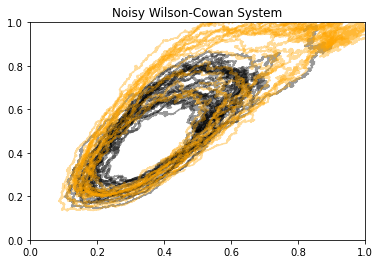

In [21]:
plt.plot(
    states[:,0,:num_samples//2],
    states[:,1,:num_samples//2],
    alpha=0.4, color='black')

# orange is the new black
plt.plot(
    states[:,0,num_samples//2:],
    states[:,1,num_samples//2:],
    alpha=0.4, color='orange')
plt.xlim((0.,1.))
plt.ylim((0.,1.))
plt.title("Noisy Wilson-Cowan System");

It's hard to make sense of fractions of firing neurons greater than 100%, so let's reconsider the diffusion term (the strength of the noise). Perhaps it should depend on the fraction of activated neurons, similar to a Bernoulli random variable.

In [22]:
diffusion_strength = lambda t,state: np.diag(state*(1.-state))

# repeat integration
states = np.zeros((times.shape[0], state0.shape[0], num_samples))
states[0,:,:num_samples//2] = state0.reshape(-1,1).repeat(num_samples//2,1)
states[0,:,num_samples//2:] = state0_v2.reshape(-1,1).repeat(num_samples//2,1)

# Integrate with Euler-Maruyama method
# we can parallelise obtaining multiple samples,
# but I shan't here
for sample_idx in range(num_samples):
    for i, t in enumerate(times[:-1]):
        differential = stochastic_differential(
            t=t,
            state=states[i,:,sample_idx],
            drift_func=wilson_cowan_derivative,
            diffusion_func=diffusion_strength,
            brownian_covariance=brownian_covariance,
            covariance_is_diagonal=False,
            delta_t=delta_t)
        states[i+1,:,sample_idx] = states[i,:,sample_idx] + differential*delta_t

In [23]:
plt.plot(
    states[:,0,:num_samples//2],
    states[:,1,:num_samples//2],
    alpha=0.4, color='black')

# orange is the new black
plt.plot(
    states[:,0,num_samples//2:],
    states[:,1,num_samples//2:],
    alpha=0.4, color='orange')
plt.xlim((0.,1.))
plt.ylim((0.,1.))
plt.title("Another Noisy Wilson-Cowan System");

This integration can all be wrapped up into a single function.

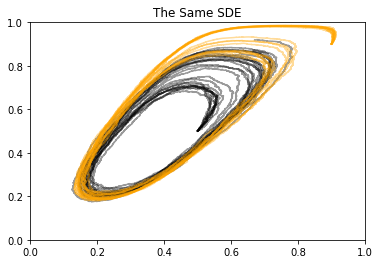

In [28]:
for colour, init_state in zip(
    ['black', 'orange'],
    [state0, state0_v2]
):
    for i in range(num_samples//2):
        x,y = sdeint_em(
            wilson_cowan_derivative, diffusion_strength, init_state,
            t_eval=times, brownian_covariance=brownian_covariance).T
        plt.plot(x,y, color=colour, alpha=0.4)
plt.xlim((0.,1.))
plt.ylim((0.,1.))
plt.title("The Same SDE");